In [2]:
import pandas as pd

df = pd.read_csv("rawdata_new.csv")

all_features = df.columns

# Let's drop some features
names = [feat for feat in all_features if "net_name" in feat] # excluded for privacy reasons
useless = ["info_gew","info_resul","interviewtime","id","date"] # features that we expect are uninformative
drop_list = names + useless 

# Remove the questionnaire about agricultural practices until I can better understand it
practice_list = ["legum","conc","add","lact","breed","covman","comp","drag","cov","plow","solar","biog","ecodr"]
for feat in all_features:
    if any(x in feat for x in practice_list):
        drop_list.append(feat)


df = df.drop(columns=drop_list)

# Convert non-numeric features to numeric
non_numeric = list(df.select_dtypes(include=['O']).columns)
for col in non_numeric:
    codes,uniques=pd.factorize(df[col])
    df[col] = codes

df.to_csv("data_processed.csv")

c:\Users\SHEKHAR\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\SHEKHAR\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\SHEKHAR\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


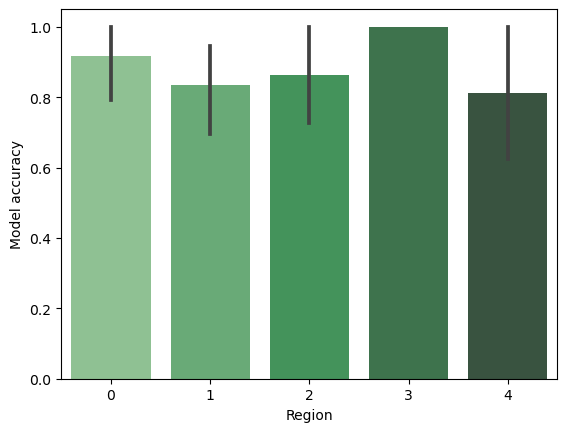

In [3]:
import pandas as pd 
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

df = pd.read_csv("data_processed.csv")

#### Get features ready to model! 
y = df.pop("cons_general").to_numpy()
y[y< 4] = 0
y[y>= 4] = 1

X = df.to_numpy()
X = preprocessing.scale(X) # Is standard
# Impute NaNs

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X)
X = imp.transform(X)


# Linear model
clf = LogisticRegression()
yhat = cross_val_predict(clf, X, y, cv=5)

acc = np.mean(yhat==y)
tn, fp, fn, tp = confusion_matrix(y, yhat).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp + fn)

# Now print to file
with open("metrics.json", 'w') as outfile:
        json.dump({ "accuracy": acc, "specificity": specificity, "sensitivity":sensitivity}, outfile)

# Let's visualize within several slices of the dataset
score = yhat == y
score_int = [int(s) for s in score]
df['pred_accuracy'] = score_int

# Bar plot by region

sns.set_color_codes("dark")
ax = sns.barplot(x="region", y="pred_accuracy", data=df, palette = "Greens_d")
ax.set(xlabel="Region", ylabel = "Model accuracy")
plt.savefig("by_region.png",dpi=80)